In [54]:
""" 
Functionality to add:
    - Way to compare the calibration curve of different models (or subsets)
"""

' \nFunctionality to add:\n    - Way to compare the calibration curve of different models (or subsets)\n    \n'

In [105]:
class Test():

    def __init__(self):
        pass

    def test(self):
        return self.__class__.__name__

    @staticmethod
    def test2():
        return 5


class Test2():

    def __init__(self):
        pass

    def test2(self):
        return Test.test(self)


x = Test()
x.test2()

5

In [1]:
import pickle
from os.path import join
from os import listdir

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression

import UD_draft_model.data_processing.read_data as read_data
import UD_draft_model.data_processing.prepare_drafts as prepare_drafts
# https://neptune.ai/blog/evaluation-metrics-binary-classification

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 300)

DATA_FOLDER = '/home/cdelong/Python-Projects/UD-Draft-Model/Repo-Work/UD-Draft-Model/data'
RANKS_FOLDER = '/home/cdelong/Python-Projects/UD-Draft-Model/Repo-Work/UD-Draft-Model\
/data/2022/player_ranks'

NUM_PLAYERS = 200


def load_obj(file_path: str):
    dbfile = open(file_path, 'rb')
    df = pickle.load(dbfile)
    dbfile.close()

    return df


class ModelVersion:
    """ 
    Allows a model to be saved along with additional metadata.
    """

    _metatdata_items = [
        'model', 'model_number', 'data_number', 'model_description', 'features'
    ]

    def __init__(self, model, metadata: dict, **model_args) -> None:
        self.model = model(**model_args)
        self.metadata = ModelVersion._validate_metadata(metadata)

    @staticmethod
    def _validate_metadata(metadata: dict) -> dict:
        """ 
        Ensures all required metadata items are included
        """

        for item in ModelVersion._metatdata_items:
            if item not in(metadata.keys()):
                raise Exception(f'{item} is a required metadata item')

        return metadata

    def pickle_obj(self, path: str, overwrite: bool=False) -> None:
        """
        Save the object as a pickle file.
        """

        filename = self._model_name()

        if overwrite == False:
            files = listdir(path)

            if filename in(files):
                print(f'{filename} already exists')

                return None

        # This will only run if overwrite is true or the file does not exist.
        dbfile = open(join(path, filename), 'wb')
        
        pickle.dump(self, dbfile)                     
        dbfile.close()


    def _model_name(self) -> str:
        """ 
        Creates a unique model name that will be used to save the model.
        """

        model = self.metadata['model']
        data_number = self.metadata['data_number']
        model_number = self.metadata['model_number']
        
        return f'{model}_{data_number}_{model_number}'


def _add_current_rank(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Adds derived rank for each draft/player based off adp.
    Note that even early round derived ranks won't align
    with actual due to multiple players having the same ADP.
    """

    by_vars = ['draft_id', 'number']
    df['avail_cur_rank_actual'] = 1
    df['avail_cur_rank_actual'] = df.groupby(by_vars)['avail_cur_rank_actual'].cumsum()

    return df


def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a handful of basic features that capture each players ranking
    relative to the nex pick
    """

    df = _add_current_rank(df)

    df['picks_btwn'] = df['next_pick_number'] - df['number']
    df['diff_cur_rank_picks_btwn'] = df['avail_cur_rank_actual'] -\
        df['picks_btwn']

    ind_rank_btwn = np.where(df['diff_cur_rank_picks_btwn'] <=0, 1, 0)
    df['ind_rank_btwn'] = ind_rank_btwn

    return df


def split_by_draft(df: pd.DataFrame, draft_col: str=None,
     test_size: float=0.2
) -> pd.DataFrame:
    """
    Splits the data into train/test dfs by draft.
    """

    if draft_col is None:
        draft_col = 'draft_id'

    splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=7)
    split = splitter.split(df, groups=df[draft_col])
    train_inds, test_inds = next(split)

    df_train = df.iloc[train_inds]
    df_test = df.iloc[test_inds]

    return df_train, df_test


# df_ranks = read_data.read_ranks(DATA_FOLDER, [2021, 2022])
# df_lookups = read_data.read_lookups(DATA_FOLDER, [2021, 2022])
# df_drafts = read_data.read_drafts(DATA_FOLDER, [2021, 2022])

# df_updated_types = prepare_drafts.update_dtypes(df_drafts)
# df_complete_players = prepare_drafts.drafts_w_player_data(df_updated_types)
# df_draft_attrs = prepare_drafts.add_draft_attrs(df_complete_players)
# df_w_rank_type = prepare_drafts.add_draft_rank_type(df_draft_attrs)
# df_w_rank_lookups = prepare_drafts.add_ranks_lookups(df_w_rank_type, df_lookups)
# df_expanded = prepare_drafts.expand_all_drafts(df_w_rank_lookups, df_ranks, NUM_PLAYERS)
# df_final = prepare_drafts.add_picked_indicator(df_expanded)

# df_final = prepare_drafts.process_data(df_drafts, df_ranks, df_lookups, NUM_PLAYERS)

# df_model = add_features(df_final.copy())

df_model

,drafted_player_key,avail_player_key,avail_rank_actual,avail_team,avail_position,avail_projection_adp,appearance_id,created_at,draft_entry_id,number,projection_adp,draft_id,draft_source,draft_title,num_teams,round,round_pick,draft_datetime,draft_date,draft_year,ranks_type,drafted_player,drafted_team,drafted_position,ranks_draft_date,avail_number,next_pick_number,ind_avail,ind_picked
0,Christian McCaffrey - 2021-08-24 - 1.0,Christian McCaffrey - 2021-08-24 - 1.0,1,Carolina Panthers,RB,1.0,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-08-25 01:44:33,74b3fdcc-6128-4e7a-ae1a-fda04c1859d3,1,1.0,d525469e-276a-4cf3-ad07-a268841faea3,NaN,NaN,12,1,1,2021-08-25 01:44:33,2021-08-25,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-08-24,1.0,24.0,0,1
1,Christian McCaffrey - 2021-08-24 - 1.0,Dalvin Cook - 2021-08-24 - 2.1,2,Minnesota Vikings,RB,2.1,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-08-25 01:44:33,74b3fdcc-6128-4e7a-ae1a-fda04c1859d3,1,1.0,d525469e-276a-4cf3-ad07-a268841faea3,NaN,NaN,12,1,1,2021-08-25 01:44:33,2021-08-25,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-08-24,2.0,24.0,0,1
2,Christian McCaffrey - 2021-08-24 - 1.0,Alvin Kamara - 2021-08-24 - 3.7,3,New Orleans Saints,RB,3.7,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-08-25 01:44:33,74b3fdcc-6128-4e7a-ae1a-fda04c1859d3,1,1.0,d525469e-276a-4cf3-ad07-a268841faea3,NaN,NaN,12,1,1,2021-08-25 01:44:33,2021-08-25,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-08-24,3.0,24.0,0,1
3,Christian McCaffrey - 2021-08-24 - 1.0,Derrick Henry - 2021-08-24 - 4.3,4,Tennessee Titans,RB,4.3,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-08-25 01:44:33,74b3fdcc-6128-4e7a-ae1a-fda04c1859d3,1,1.0,d525469e-276a-4cf3-ad07-a268841faea3,NaN,NaN,12,1,1,2021-08-25 01:44:33,2021-08-25,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-08-24,4.0,24.0,0,1
4,Christian McCaffrey - 2021-08-24 - 1.0,Ezekiel Elliott - 2021-08-24 - 5.6,5,Dallas Cowboys,RB,5.6,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-08-25 01:44:33,74b3fdcc-6128-4e7a-ae1a-fda04c1859d3,1,1.0,d525469e-276a-4cf3-ad07-a268841faea3,NaN,NaN,12,1,1,2021-08-25 01:44:33,2021-08-25,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-08-24,5.0,24.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4814917,Tyrion Davis-Price - 2022-05-15 - 179.8,Ty Johnson - 2022-05-15 - 216.0,396,NYJ,RB,216.0,cb618523-b22c-40d6-825c-a0ced8339239,2022-05-15 23:58:14,c488824b-b11d-42f0-b16c-e59fc361e425,203,179.8,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,17,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Tyrion Davis-Price,SF,RB,2022-05-15,9999.0,206.0,1,0
4814918,Tyrion Davis-Price - 2022-05-15 - 179.8,Travis Fulgham - 2022-05-15 - 216.0,397,DEN,WR,216.0,cb618523-b22c-40d6-825c-a0ced8339239,2022-05-15 23:58:14,c488824b-b11d-42f0-b16c-e59fc361e425,203,179.8,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,17,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Tyrion Davis-Price,SF,RB,2022-05-15,9999.0,206.0,1,0
4814919,Tyrion Davis-Price - 2022-05-15 - 179.8,Brandon Allen - 2022-05-15 - 216.0,398,CIN,QB,216.0,cb618523-b22c-40d6-825c-a0ced8339239,2022-05-15 23:58:14,c488824b-b11d-42f0-b16c-e59fc361e425,203,179.8,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,17,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Tyrion Davis-Price,SF,RB,2022-05-15,9999.0,206.0,1,0
4814920,Tyrion Davis-Price - 2022-05-15 - 179.8,Salvon Ahmed - 2022-05-15 - 216.0,399,MIA,RB,216.0,cb618523-b22c-40d6-825c-a0ced8339239,2022-05-15 23:58:14,c488824b-b11d-42f0-b16c-e59fc361e425,203,179.8,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,17,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Tyrion Davis-Price,SF,RB,2022-05-15,9999.0,206.0,1,0


In [3]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression


def split_by_draft(df: pd.DataFrame, draft_col: str=None,
     test_size: float=0.2
) -> pd.DataFrame:
    """
    Splits the data into train/test dfs by draft.
    """

    if draft_col is None:
        draft_col = 'draft_id'

    splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=7)
    split = splitter.split(df, groups=df[draft_col])
    train_inds, test_inds = next(split)

    df_train = df.iloc[train_inds]
    df_test = df.iloc[test_inds]

    return df_train, df_test


def fit_model(df_train: pd.DataFrame, features: list
    , response: str, **kwargs
) -> LogisticRegression:
    """
    Fits a logistic regression model to the training data passed.
    """

    x_train = df_train[features]
    y_train = df_train[response]

    log = LogisticRegression(**kwargs)
    log.fit(x_train, y_train)

    return log


df_train, df_test = split_by_draft(df_model.copy(), draft_col='draft_id'
    , test_size=0.2
)

features = ['diff_cur_rank_picks_btwn', 'ind_rank_btwn']
response = ['ind_picked']

x_train = df_train[features]
y_train = df_train[response]

x_test = df_test[features]
y_test = df_test[response]


In [43]:
def fit_model(df_train: pd.DataFrame, features: list
    , response: str, **kwargs
) -> LogisticRegression:
    """
    Fits a logistic regression model to the training data passed.
    """

    x_train = df_train[features]
    y_train = df_train[response]

    log = LogisticRegression(**kwargs)
    log.fit(x_train, y_train)

    return log

features = ['diff_cur_rank_picks_btwn', 'ind_rank_btwn']
log = fit_model(df_train.copy(), features, 'ind_picked')

y_pred = log.predict(x_test)

y_pred_prob = log.predict_proba(x_test)
y_pred_prob = y_pred_prob[:,1]

loss = brier_score_loss(y_test, y_pred_prob)
loss

0.026780912689744762

In [92]:
features = ['diff_cur_rank_picks_btwn', 'ind_rank_btwn']
response = 'ind_picked'

x_train = df_train[features]
y_train = df_train[response]

model_metadata = {
    'model': 'LogisticRegression',
    'model_number': 'v002',
    'data_number': 'v01',
    'model_description': 'logistic regression with # of picks between and '
        'indicator for picks between',
    'features': None
}
log = Model(LogisticRegression, model_metadata)
log.model.fit(x_train, y_train)

y_pred = log.model.predict(x_test)

y_pred_prob = log.model.predict_proba(x_test)
y_pred_prob = y_pred_prob[:,1]

loss = brier_score_loss(y_test, y_pred_prob)
loss

log.pickle_obj(join(DATA_FOLDER, 'models'), overwrite=True)

In [31]:
log = LogisticRegression(fit_intercept=True)
log = log.fit(x_train, y_train)

y_pred = log.predict(x_test)

y_pred_prob = log.predict_proba(x_test)
y_pred_prob = y_pred_prob[:,1]

loss = brier_score_loss(y_test, y_pred_prob)
loss

/home/cdelong/Python-Projects/UD-Draft-Model/Repo-Work/UD-Draft-Model/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.026780912689744762

In [245]:
df_test_concat = df_test.drop(columns=response)

y_test_w_cols = pd.concat([y_test, df_test_concat], axis=1)
y_test_w_cols.reset_index(inplace=True, drop=True)

df_y_pred_prob = pd.DataFrame(y_pred_prob, columns=['prob'])

df_test_all = pd.concat([y_test_w_cols, df_y_pred_prob], axis=1)

_df = df_test_all.loc[df_test_all['draft_id'] == '8661e28d-4e17-4120-b4a7-4b2e7e8b7de7']

_df_g = df_test_all.groupby(['draft_id', 'number'])['prob'].sum().to_frame('prob_sum').reset_index()

df_test_all = pd.merge(df_test_all, _df_g, on=['draft_id', 'number'], how='left')
df_test_all['prob_new'] = df_test_all['prob'] * (df_test_all['picks_btwn'] / df_test_all['prob_sum'])

df_test_all.loc[df_test_all['prob_new'] > 1]

# y_test_new = df_test_all['ind_picked']
# y_pred_prob_new = df_test_all['prob_new']

# loss = brier_score_loss(y_test, y_pred_prob)
# loss_filt = brier_score_loss(y_test_new, y_pred_prob_new)

_df = df_test_all
conds = ((_df['draft_id'] == '8661e28d-4e17-4120-b4a7-4b2e7e8b7de7')
        & (_df['number'] == 1))

_df['prob'] = _df['prob'].round(4)
_df['prob_new'] = _df['prob_new'].round(6)
_df['prob_sum'] = _df['prob_sum'].round(4)

_df = _df.loc[conds].copy()
_df['diff'] = _df['prob_new'] - _df['prob']

_df
# _df['diff'].sum()
# _df['prob_new'].sum()
# print(loss)
# print(loss_filt)

,ind_picked,drafted_player_key,avail_player_key,avail_rank_actual,avail_team,avail_position,avail_projection_adp,appearance_id,created_at,draft_entry_id,number,projection_adp,draft_id,draft_source,draft_title,num_teams,round,round_pick,draft_datetime,draft_date,draft_year,ranks_type,drafted_player,drafted_team,drafted_position,ranks_draft_date,avail_number,next_pick_number,ind_avail,avail_cur_rank_actual,picks_btwn,diff_cur_rank_picks_btwn,ind_rank_btwn,ind_picked_v2,prob,prob_sum,prob_new,diff
0,1,Christian McCaffrey - 2021-07-24 - 1.0,Christian McCaffrey - 2021-07-24 - 1.0,1,Carolina Panthers,RB,1.0,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,1.0,24.0,0,1,23.0,-22.0,1,1,0.9771,22.3121,1.007204,0.030104
1,1,Christian McCaffrey - 2021-07-24 - 1.0,Dalvin Cook - 2021-07-24 - 2.1,2,Minnesota Vikings,RB,2.1,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,2.0,24.0,0,2,23.0,-21.0,1,0,0.9733,22.3121,1.003267,0.029967
2,1,Christian McCaffrey - 2021-07-24 - 1.0,Derrick Henry - 2021-07-24 - 3.6,3,Tennessee Titans,RB,3.6,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,3.0,24.0,0,3,23.0,-20.0,1,0,0.9688,22.3121,0.998694,0.029894
3,1,Christian McCaffrey - 2021-07-24 - 1.0,Alvin Kamara - 2021-07-24 - 4.4,4,New Orleans Saints,RB,4.4,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,5.0,24.0,0,4,23.0,-19.0,1,0,0.9637,22.3121,0.993392,0.029692
4,1,Christian McCaffrey - 2021-07-24 - 1.0,Ezekiel Elliott - 2021-07-24 - 5.6,5,Dallas Cowboys,RB,5.6,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,4.0,24.0,0,5,23.0,-18.0,1,0,0.9577,22.3121,0.987252,0.029552
5,1,Christian McCaffrey - 2021-07-24 - 1.0,Travis Kelce - 2021-07-24 - 6.2,6,Kansas City Chiefs,TE,6.2,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,7.0,24.0,0,6,23.0,-17.0,1,0,0.9508,22.3121,0.980158,0.029358
6,1,Christian McCaffrey - 2021-07-24 - 1.0,Saquon Barkley - 2021-07-24 - 7.3,7,NY Giants,RB,7.3,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,6.0,24.0,0,7,23.0,-16.0,1,0,0.9429,22.3121,0.971977,0.029077
7,1,Christian McCaffrey - 2021-07-24 - 1.0,Tyreek Hill - 2021-07-24 - 8.0,8,Kansas City Chiefs,WR,8.0,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,9.0,24.0,0,8,23.0,-15.0,1,0,0.9338,22.3121,0.962567,0.028767
8,1,Christian McCaffrey - 2021-07-24 - 1.0,Jonathan Taylor - 2021-07-24 - 9.2,9,Indianapolis Colts,RB,9.2,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e1

In [242]:
0.68 / 200

0.0034000000000000002

In [52]:
df_test_concat = df_test.drop(columns=response)

y_test_w_cols = pd.concat([y_test, df_test_concat], axis=1)
y_test_w_cols.reset_index(inplace=True, drop=True)

y_pred_prob_filt = pd.DataFrame(y_pred_prob, columns=['prob'])

y_test_filt = y_test_w_cols.loc[y_test_w_cols['diff_cur_rank_picks_btwn'] <= 10]
# y_test_filt = y_test_w_cols.loc[y_test_w_cols['round'] == 14]
# y_test_filt = y_test_w_cols.loc[y_test_w_cols['round_pick'] == 6]
y_test_filt = y_test_filt[response]
y_pred_prob_filt = y_pred_prob_filt[y_pred_prob_filt.index.isin(y_test_filt.index)]

loss = brier_score_loss(y_test, y_pred_prob)
loss_filt = brier_score_loss(y_test_filt, y_pred_prob_filt)

print(loss)
print(loss_filt)

0.026780912689744762
0.14753285038903025


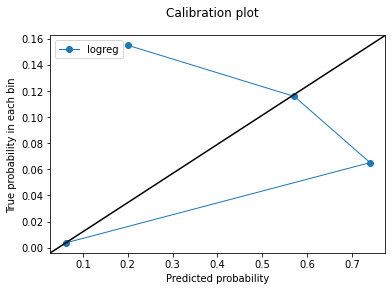

In [27]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# actual, pred = calibration_curve(y_test, y_pred_prob, n_bins=20)
actual, pred = calibration_curve(y_test_new, y_pred_prob_new, n_bins=20)
# actual, pred = calibration_curve(y_test_filt, y_pred_prob_filt, n_bins=40, strategy='quantile')

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(actual, pred, marker='o', linewidth=1, label='logreg')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

In [ ]:
###############################################################################
################################## SCRATCH ####################################
###############################################################################

In [57]:
_df = df_model.copy()

conds = ((_df['draft_id'] == '133d89ab-ba4f-4230-9148-396bee781f5c')
        & (_df['number'] == 11)
        # & (_df['avail_cur_rank_actual'] == 1)
        # & (_df['draft_entry_id'] == 'c488824b-b11d-42f0-b16c-e59fc361e425')
        )
_df.loc[conds]

,drafted_player_key,avail_player_key,avail_rank_actual,avail_team,avail_position,avail_projection_adp,appearance_id,created_at,draft_entry_id,number,projection_adp,draft_id,draft_source,draft_title,num_teams,round,round_pick,draft_datetime,draft_date,draft_year,ranks_type,drafted_player,drafted_team,drafted_position,ranks_draft_date,avail_number,next_pick_number,ind_avail,avail_cur_rank_actual,picks_btwn,diff_cur_rank_picks_btwn,ind_rank_btwn,ind_picked
4776325,Davante Adams - 2022-05-15 - 9.9,Davante Adams - 2022-05-15 - 9.9,9,LV,WR,9.9,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,11.0,14.0,0,1,3.0,-2.0,1,1
4776326,Davante Adams - 2022-05-15 - 9.9,Joe Mixon - 2022-05-15 - 12.2,12,CIN,RB,12.2,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,12.0,14.0,0,2,3.0,-1.0,1,1
4776327,Davante Adams - 2022-05-15 - 9.9,Travis Kelce - 2022-05-15 - 12.6,13,KC,TE,12.6,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,13.0,14.0,0,3,3.0,0.0,1,1
4776328,Davante Adams - 2022-05-15 - 9.9,CeeDee Lamb - 2022-05-15 - 14.3,14,DAL,WR,14.3,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,14.0,14.0,1,4,3.0,1.0,0,0
4776329,Davante Adams - 2022-05-15 - 9.9,Deebo Samuel - 2022-05-15 - 16.6,15,SF,WR,16.6,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,18.0,14.0,1,5,3.0,2.0,0,0
4776330,Davante Adams - 2022-05-15 - 9.9,Mark Andrews - 2022-05-15 - 17.3,16,BAL,TE,17.3,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,15.0,14.0,1,6,3.0,3.0,0,0
4776331,Davante Adams - 2022-05-15 - 9.9,D'Andre Swift - 2022-05-15 - 17.6,17,DET,RB,17.6,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,16.0,14.0,1,7,3.0,4.0,0,0
4776332,Davante Adams - 2022-05-15 - 9.9,Alvin Kamara - 2022-05-15 - 19.1,18,NO,RB,19.1,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,17.0,14.0,1,8,3.0,5.0,0,0
4776333,Davante Adams - 2022-05-15 - 9.9,Tyreek Hill - 2022-05-15 - 20.1,19,MIA,WR,20.1,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,26.0,14.0,1,9,3.0,6.0,0,0
4776334,Davante Adams - 2022-05-15 - 9.9,Mike Evans - 2022-05-15 - 20.2,20,TB,WR,20.2,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,20.0,14.0,1,10,3.0,7.0,0,0


In [6]:
_df = df_final.groupby('ind_avail').size().to_frame('num_players').reset_index()
_df['perc_players'] = _df['num_players'] / len(df_final)

_df

,ind_avail,num_players,perc_players
0,0,438328,0.093861
1,1,4231630,0.906139


In [49]:
splitter = GroupShuffleSplit(test_size=0.20, n_splits=10, random_state=7)
split = splitter.split(df, groups=df['draft_id'])
a = [1, 2]

for i, check in enumerate(split):
    if i == 0:
        print(len(check[1]))
    else:
        break

1024242


In [40]:
# _df = df_train.copy()
# _df = _df.groupby(['draft_year'], dropna=False)['draft_id'].nunique().to_frame('num_picks')

num_train = df_train['draft_id'].nunique()
num_test = df_test['draft_id'].nunique()

print(num_train)
print(num_test)
print(num_train + num_test)
print(df_model['draft_id'].nunique())
print(num_train / (num_train + num_test))

124
32
156
156
0.7948717948717948


In [12]:
# accuracy = metrics.accuracy_score(y_test, y_pred)
# accuracy_percentage = 100 * accuracy

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(recall)
print(precision)

0.7931172291296625
0.7931172291296625


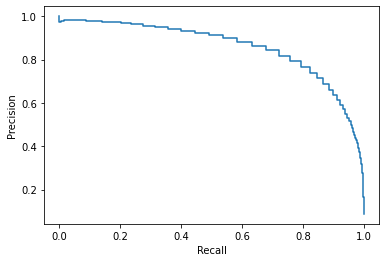

In [13]:
precision, recall, threshold = precision_recall_curve(y_test, 
                                                      y_pred_prob)
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()

In [25]:
# precision[196:]
# recall[197:]
threshold[196:]

array([0.35637088, 0.56847159, 0.60674675, 0.64375449, 0.67912138,
       0.71254498, 0.74380048, 0.77274141, 0.79929527, 0.82345531,
       0.84527006, 0.86483174, 0.8822648 , 0.89771539, 0.91134213,
       0.92330855, 0.93377719, 0.94290519, 0.95084124, 0.95772366,
       0.96367933, 0.9688233 , 0.97325896, 0.97707847, 0.98036344])

In [11]:
_df = df_train.copy()
_df = _df.groupby(['draft_year'], dropna=False)['draft_id'].nunique().to_frame('num_picks')

_df

,num_picks
draft_year,
2021,88
2022,36


In [219]:
import random

def create_random_draws(n_players: int, n_selections: int, n_draws: int) -> np.array:
    # n_players = 5
    # n_selections = 2

    # n_draws = 5

    # players = np.arange(0, n_players)

    all_selections = np.zeros(shape=(n_draws, n_selections))
    for n_draw in range(n_draws):
        players = np.arange(0, n_players)
        selections = np.zeros(n_selections)
        for n_selection in range(n_selections):
            player_index = random.randint(0, len(players) - 1)

            selections[n_selection] = players[player_index]

            players = np.delete(players, player_index)

        all_selections[n_draw] = selections

    return all_selections


def calc_perc_draws(draws: np.array, n_players: int) -> np.array:
    counts = np.zeros(n_players)

    for draw in draws:
        for player_index in range(n_players):
            if player_index in(draw):
                counts[player_index] += 1

    for player_index in range(n_players):
        counts[player_index] = counts[player_index] / len(draws) 

    return counts

n_players = 200
n_selections = 20
n_draws = 100

draws = create_random_draws(n_players, n_selections, n_draws)
perc_draws = calc_perc_draws(draws, n_players)

total = sum(perc_draws)
total
# draw = draws[0]

# if 5 in(draw):
#     print('yes')
# else:
#     print('no')



19.99999999999997

In [31]:
import pandas as pd
import numpy as np

x = [['a '], [1], ['b'], ['b']]

df = pd.DataFrame(x, columns=['x'])
vals = list(set(df['x'].astype(str).str.strip().values))

df['x'] = df['x'].astype(str).str.strip()

for val in vals:
    df[val] = np.where(df['x'] == val, 1, 0)

# df['check'] = np.where(df['x'] == 'a', 1, 0)

df

,x,b,1,a
0,a,0,0,1
1,1,0,1,0
2,b,1,0,0
3,b,1,0,0
